### Data Collection & Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import time
import os
import shutil
import numpy as np
import torch
import random

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torchvision.datasets as datasets


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Data Processing and Augmentation

In [4]:
# Define a custom transformation for rotation of 45 degrees with 50% chance
class RandomRotation(object):
    def __call__(self, img):
        if random.random() < 0.5:
            return img.rotate(45)
        return img

In [5]:
data_dir = "/content/gdrive/My Drive/APS360 Project Dataset/all_data"
# Load and transform data using ImageFolder
# Compose transformations: RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
data_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    RandomRotation(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])
all_data = datasets.ImageFolder(data_dir, transform=data_transform)

# for images, _ in data_loader:
#   print(images.shape)
#   print(images)
#   break


Data Augmentation: For each image there will be a 50% chance of horizontal inversion,
and a 50% chance of a rotation of 45 degrees. Additionally we will normalize each image along
each of the R, G, and B channels to have a mean of zero and a variance of one, centering the data on
0.

Visualize Some Data

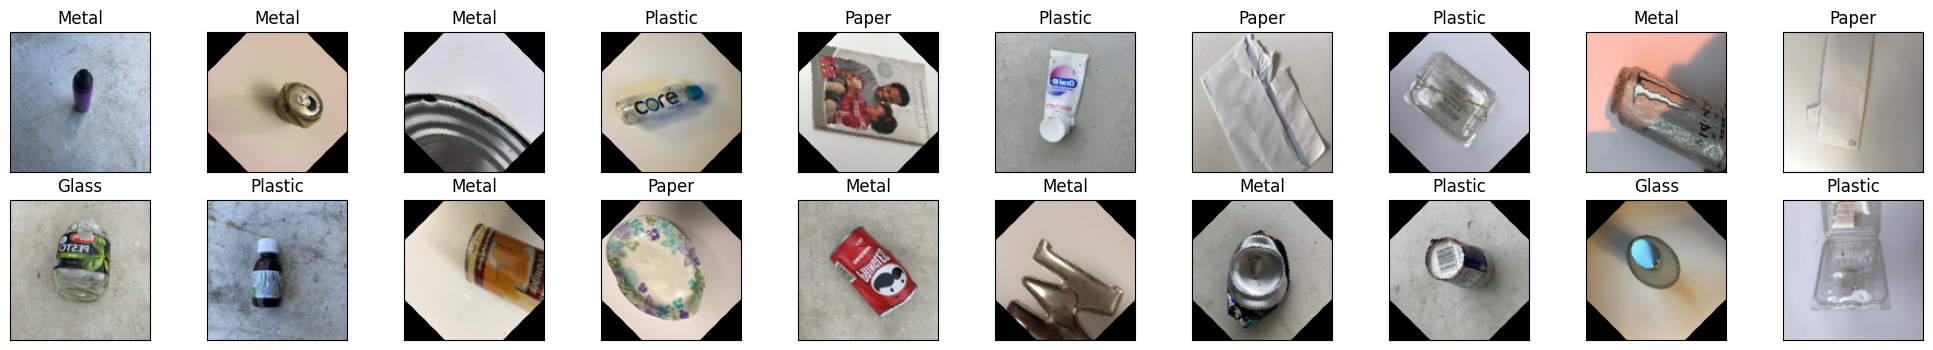

In [ ]:
#define waste classes - folders in each directory with these names
classes = ['Glass', 'Metal', 'Paper', 'Plastic']

data_loader = torch.utils.data.DataLoader(all_data, batch_size=20,
                                           num_workers=1, shuffle=True)
# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = next(dataiter)

#print(labels)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])  # Use class_names instead of classes

#Splitting Data In Train-Valid-Test

Ideally, we want a balanced dataset with an even amount of images in each class. We choose to use the class with the least amount of data for all classes and split the data into the training, validation, and test sets accordingly. For the test set, in addition to using the sample data, it will also contain new data taken by the students.

In [ ]:
def countFiles(path):
    num_items = 0
    for _,_,files in os.walk(path):
        num_items += len(files)
    return num_items

glass_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Glass"
metal_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Metal"
paper_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Paper"
plastic_path = "/content/gdrive/My Drive/APS360 Project Dataset/all_data/Plastic"
glass = countFiles(glass_path)
metal = countFiles(metal_path)
paper = countFiles(paper_path)
plastic = countFiles(plastic_path)
print("Number of Glass:", glass)
print("Number of Metal:", metal)
print("Number of Paper:", paper)
print("Number of Plastic:", plastic)

Number of Glass: 928
Number of Metal: 976
Number of Paper: 940
Number of Plastic: 949


Given that the Glass category contains the minimum number of images, we aim to leave around 900+ samples in each. This will reduce any biases and allow our model to generalize better, leading to more accurate results. As we had issues obtaining the token to use the Google Drive API, this was done manually by deleting random photos from each class

In [ ]:
glass_new = countFiles(glass_path)
metal_new = countFiles(metal_path)
paper_new = countFiles(paper_path)
plastic_new = countFiles(plastic_path)
print("Number of Glass:", glass_new)
print("Number of Metal:", metal_new)
print("Number of Paper:", paper_new)
print("Number of Plastic:", plastic_new)

Number of Glass: 928
Number of Metal: 976
Number of Paper: 940
Number of Plastic: 949


### Train-Val-Test Ratios
A 70-15-15 split was selected to split our data (with slightly more images in the test as wish to test the photos taken ourselves on the final model). This will ensure that there is a sufficient amount of data for the model to train on without risk of overfitting during hyperparameter tuning, and also leaves enough to show the final, unbiased results when we test the baseline.

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input = '/content/gdrive/My Drive/APS360 Project Dataset/all_data'
splitData = '/content/gdrive/My Drive/APS360 Project Dataset/split_data'
# split data to train, val, and test into 70%, 15% and 15%, respectively
# as we are adding in our own pictures to the test set, the ratios will be slightly different to accomodate for this
#splitfolders.ratio(input, output=splitData, seed=1, ratio=(.7, .155, .145), group_prefix=None)

Copying files: 3793 files [01:15, 50.16 files/s]


### Building ANN

ANN Structure & Explanation:
Using Tutorial 2 (Multi-Class ANN) modified the 3-layer ANN with ReLU activation functions applied on the first and second hidden layers. The softmax activation will be used for outputting class probabilities and is not included in the architecture setup.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class ANNWasteClassifier(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier, self).__init__()
        self.name = "ANNWasteClassifier"
        self.layer1 = nn.Linear(3*128*128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 4) #output is 4 classes
    def forward(self, img):
        # Determine the batch size dynamically
        #batch_size = img.size(0)
        flattened = img.view(-1, 3*128*128)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

model = ANNWasteClassifier()

print('done')

done


#### Defining Data Loaders

In [6]:
train_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/train"
val_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/val"
test_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/test"
#For original ANN Model
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

train_loader = torch.utils.data.DataLoader(train_data, num_workers=4, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, num_workers=4, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,num_workers=4, shuffle=True)
print(len(train_loader))
print(len(val_loader))


Num training images:  2654
Num validation images:  586
Num testing images:  553
83
19


Training Code

In [7]:
def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name,learning_rate,epoch)
    return path

In [8]:
def get_accuracy(model, loader, device):
    """Compute the accuracy of the model."""
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [9]:
from torch.optim.lr_scheduler import StepLR

def train(model, train_loader, valid_loader, device, num_epochs=10, learning_rate=0.001):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) #each update, how much memory
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # LR scheduler

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    # Keep track of the best validation loss and accuracy
    best_valid_loss = float('inf')
    best_valid_acc = 0
    for epoch in range(num_epochs):
      model.train()
      total_train_loss, total_train_correct = 0, 0
      for imgs, labels in train_loader:
        #print(imgs.shape)
        #print(labels.shape)
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_correct += (predicted == labels).sum().item()

      # Learning rate scheduler step
      scheduler.step()

      # Calculate average training loss for the epoch
      train_loss = total_train_loss / len(train_loader)
      train_acc = total_train_correct / len(train_loader.dataset)
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      # Set model to evaluation mode
      model.eval()
      total_valid_loss, total_valid_correct = 0, 0

      with torch.no_grad():
          for images, labels in valid_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)

              total_valid_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_valid_correct += (predicted == labels).sum().item()

      avg_valid_loss = total_valid_loss / len(valid_loader)
      valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
      val_losses.append(avg_valid_loss)
      val_acc = get_accuracy(model, valid_loader, device)
      val_accs.append(val_acc)
      # Update best validation loss and accuracy
      if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          best_valid_acc = valid_accuracy

      print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')
      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)
    plot_training_curve(train_losses, val_losses, train_accs, val_accs)

print('done')


done


In [19]:
for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)


torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])


KeyboardInterrupt: 

In [13]:
def plot_training_curve(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Checking accuracy on small batch


In [ ]:
'''#debug_data = datasets.ImageFolder(data_dir, transform=data_transform)
model = ANNWasteClassifier()
#print(f"Model batch size: {next(model.parameters()).shape[0]}")
#print(f"Data batch size: {next(iter(debug_data))[0].shape[0]}")
train(model, train_data, batch_size = 1, num_epochs=10, print_stat=1)'''

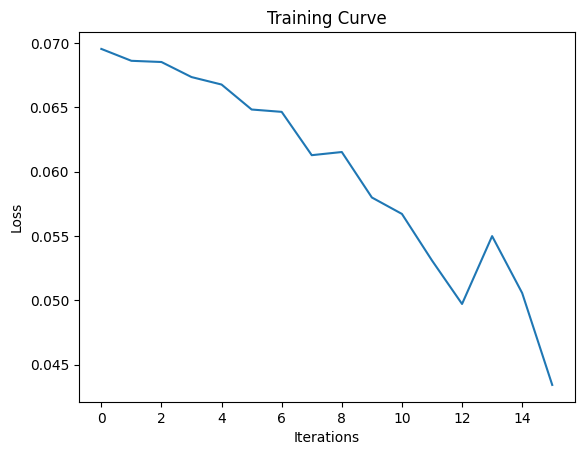

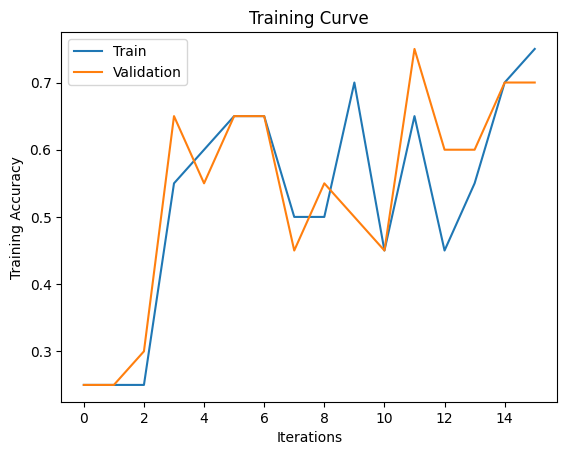

Final Training Accuracy: 0.75
Final Validation Accuracy: 0.7


In [ ]:
'''#proper model
data_dir = "/content/gdrive/My Drive/APS360 Project Dataset/mini trainset/"
debug_data = datasets.ImageFolder(data_dir, transform=data_transform)
model = ANNWasteClassifier()
train(model, debug_data, batch_size=20, num_epochs=16)'''

image dimensions:  torch.Size([3, 128, 128])
output dimensions:  torch.Size([1, 4])
output probabilities:  tensor([[0.2377, 0.2540, 0.2604, 0.2480]], grad_fn=<SoftmaxBackward0>) sum:  tensor(1., grad_fn=<SumBackward0>)
output:  2 with a probability of 0.26035770773887634
label:  tensor(2)


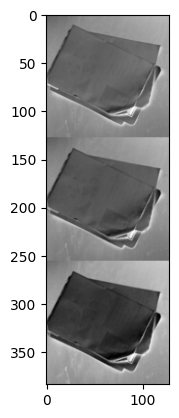

In [ ]:
debug_loader = torch.utils.data.DataLoader(debug_data, batch_size=20,
                                           num_workers=1, shuffle=True)
for images, labels in debug_loader:
    # Get the first image from the batch
    image = images[0]
    label = labels[0]
    break  # Break after fetching the first batch
#plot sample image
print('image dimensions: ', image.shape)
plt.imshow(image.view(-1,128),cmap='Greys') #make image 128 x 128 (not 1 x 28 x 28 as required by model)

#test new image
out = model(image)
prob = F.softmax(out, dim=1)
print('output dimensions: ', out.shape)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))

#print max index and compare with label
print('output: ', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item())
print('label: ', label)

On a small set of sample data, the model is able to accurately predict the image. One thing to notice is that the probabilities between classes are very close to each other.

### Training on Dataset

Initial training on 128x128 due to issues with getting the model to work.

Epoch 1, Train Loss: 1.3874, Train Acc: 0.2494, Validation Acc: 0.3157
Epoch 2, Train Loss: 1.3750, Train Acc: 0.3176, Validation Acc: 0.3754
Epoch 3, Train Loss: 1.3530, Train Acc: 0.3508, Validation Acc: 0.3481
Epoch 4, Train Loss: 1.3264, Train Acc: 0.3670, Validation Acc: 0.3925
Epoch 5, Train Loss: 1.3037, Train Acc: 0.3843, Validation Acc: 0.3976
Epoch 6, Train Loss: 1.3018, Train Acc: 0.3726, Validation Acc: 0.3942
Epoch 7, Train Loss: 1.3026, Train Acc: 0.3968, Validation Acc: 0.4027
Epoch 8, Train Loss: 1.2740, Train Acc: 0.4058, Validation Acc: 0.3959
Epoch 9, Train Loss: 1.2672, Train Acc: 0.4009, Validation Acc: 0.3959
Epoch 10, Train Loss: 1.2646, Train Acc: 0.4148, Validation Acc: 0.3925
Epoch 11, Train Loss: 1.2456, Train Acc: 0.4190, Validation Acc: 0.4181
Epoch 12, Train Loss: 1.2431, Train Acc: 0.4228, Validation Acc: 0.4215
Epoch 13, Train Loss: 1.2391, Train Acc: 0.4220, Validation Acc: 0.4147
Epoch 14, Train Loss: 1.2376, Train Acc: 0.4213, Validation Acc: 0.4096
E

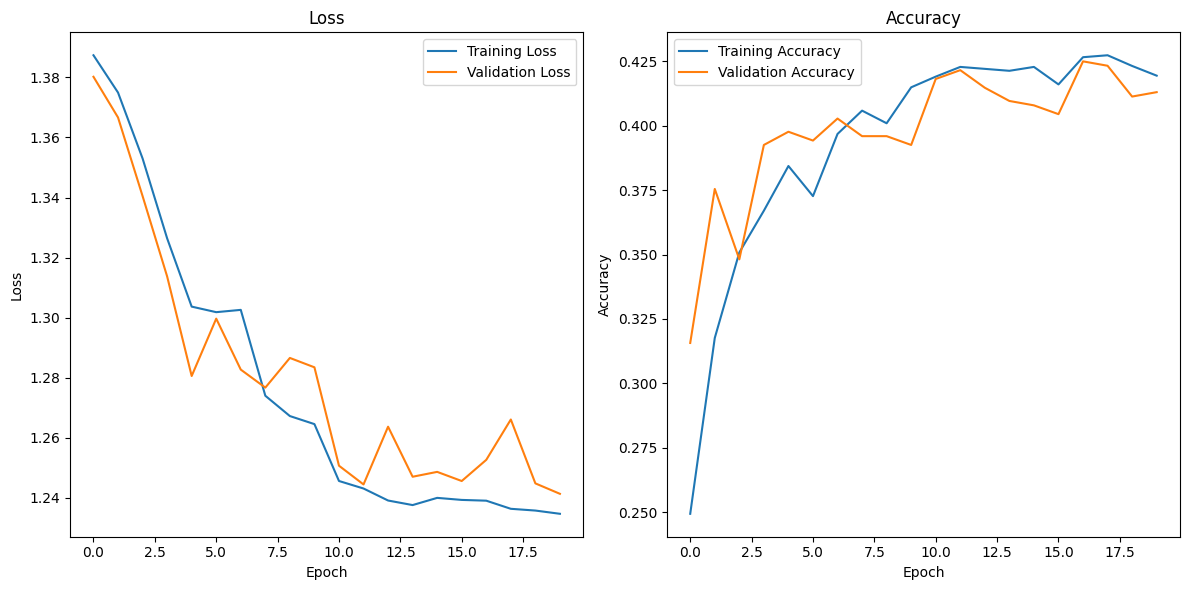

In [ ]:
model = ANNWasteClassifier().to(device)

train(model, train_loader, val_loader, device, 20, 0.001)

As we were running into issues training, we first started with the smaller image sizes until it was working. Due to computational resources and the large dataset for training, we selected 20 epochs and a 0.001 learning rate as our initial hyperparameters. Our training code utilizes a Learning Rate scheduler. This scheduler decreases the learning rate by a factor (gamma) every step_size epochs. For example, if gamma=0.1 and step_size=10, the learning rate will be decreased by a factor of 0.1 every 10 epochs.


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 4) #output is 4 classes
    def forward(self, img):
        # Determine the batch size dynamically
        #batch_size = img.size(0)
        flattened = img.view(-1, 3*256*256)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output
print('done')
data_transform256 = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    RandomRotation(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])

train_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/train"
val_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/val"
test_dir = "/content/gdrive/My Drive/APS360 Project Dataset/split_data/test"
#For original ANN Model
train_data256 = datasets.ImageFolder(train_dir, transform=data_transform256)
val_data256 = datasets.ImageFolder(val_dir, transform=data_transform256)
test_data256 = datasets.ImageFolder(test_dir, transform=data_transform256)

# print out some stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

train_loader256 = torch.utils.data.DataLoader(train_data256, batch_size=32, num_workers=4, shuffle=True)
val_loader256 = torch.utils.data.DataLoader(val_data256,  batch_size=32, num_workers=4, shuffle=True)
test_loader256 = torch.utils.data.DataLoader(test_data256, batch_size=32,num_workers=4, shuffle=True)
print(len(train_loader))
print(len(val_loader))

done
Num training images:  2654
Num validation images:  586
Num testing images:  553
83
19


This is the initial parameters used to train the model. Learning rate = 0.001, 20 epochs, batch size = 32, 3 layers

Epoch 1, Train Loss: 1.3885, Train Acc: 0.2679, Validation Acc: 0.3038
Epoch 2, Train Loss: 1.3671, Train Acc: 0.3353, Validation Acc: 0.3669
Epoch 3, Train Loss: 1.3291, Train Acc: 0.3693, Validation Acc: 0.3311
Epoch 4, Train Loss: 1.3232, Train Acc: 0.3617, Validation Acc: 0.3925
Epoch 5, Train Loss: 1.3217, Train Acc: 0.3617, Validation Acc: 0.3754
Epoch 6, Train Loss: 1.2943, Train Acc: 0.3821, Validation Acc: 0.3840
Epoch 7, Train Loss: 1.2985, Train Acc: 0.3806, Validation Acc: 0.3788
Epoch 8, Train Loss: 1.2809, Train Acc: 0.3922, Validation Acc: 0.3788
Epoch 9, Train Loss: 1.2627, Train Acc: 0.4032, Validation Acc: 0.3908
Epoch 10, Train Loss: 1.2494, Train Acc: 0.4201, Validation Acc: 0.3993
Epoch 11, Train Loss: 1.2313, Train Acc: 0.4243, Validation Acc: 0.4113
Epoch 12, Train Loss: 1.2300, Train Acc: 0.4356, Validation Acc: 0.4181
Epoch 13, Train Loss: 1.2243, Train Acc: 0.4292, Validation Acc: 0.4044
Epoch 14, Train Loss: 1.2229, Train Acc: 0.4337, Validation Acc: 0.4164
E

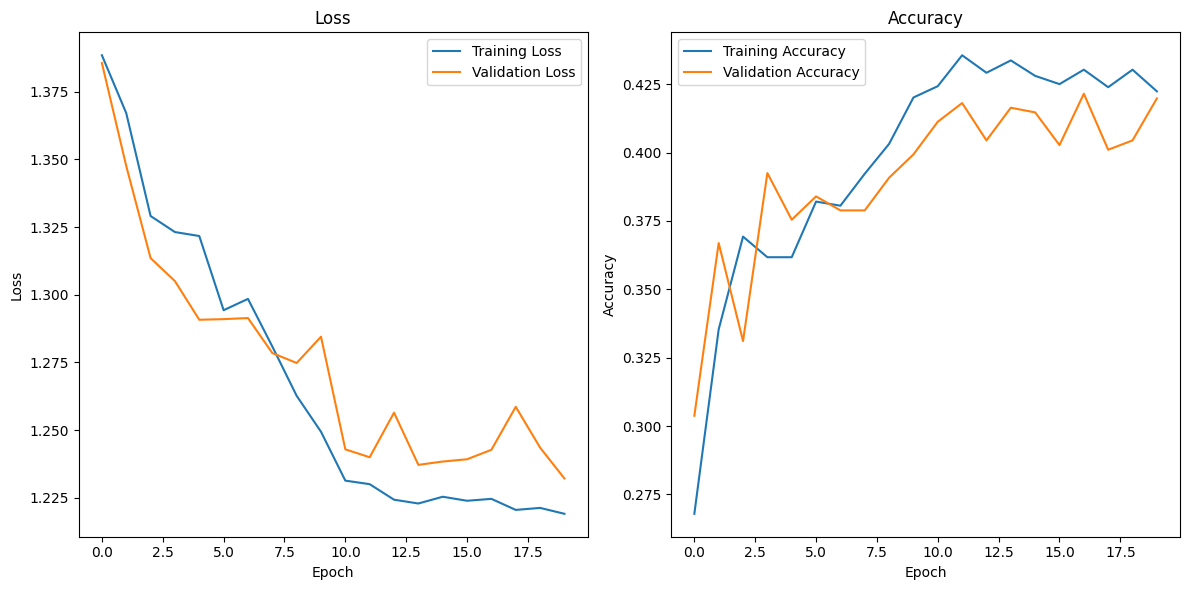

In [ ]:
model256 = ANNWasteClassifier256().to(device)
train(model256, train_loader256, val_loader256, device, 20, 0.001)

Prior to hyperparameter tuning, we decided to include batch normalization to our hidden layers to improve stability and speed up the training process.

In [ ]:
class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 4) #output is 4 classes
    def forward(self, img):
        # Determine the batch size dynamically
        #batch_size = img.size(0)
        flattened = img.view(-1, 3*256*256)
        activation1 = F.relu(self.bn1(self.layer1(flattened)))
        activation2 = F.relu(self.bn2(self.layer2(activation1)))
        output = self.layer3(activation2)
        return output

Epoch 1, Train Loss: 1.3223, Train Acc: 0.3745, Validation Acc: 0.4181
Epoch 2, Train Loss: 1.2399, Train Acc: 0.4152, Validation Acc: 0.4283
Epoch 3, Train Loss: 1.2047, Train Acc: 0.4589, Validation Acc: 0.4198
Epoch 4, Train Loss: 1.1758, Train Acc: 0.4800, Validation Acc: 0.4573
Epoch 5, Train Loss: 1.1501, Train Acc: 0.4928, Validation Acc: 0.4863
Epoch 6, Train Loss: 1.1379, Train Acc: 0.4894, Validation Acc: 0.4044
Epoch 7, Train Loss: 1.1124, Train Acc: 0.5260, Validation Acc: 0.4556
Epoch 8, Train Loss: 1.1005, Train Acc: 0.5219, Validation Acc: 0.4949
Epoch 9, Train Loss: 1.0803, Train Acc: 0.5268, Validation Acc: 0.4846
Epoch 10, Train Loss: 1.0693, Train Acc: 0.5407, Validation Acc: 0.4642
Epoch 11, Train Loss: 1.0395, Train Acc: 0.5690, Validation Acc: 0.5358
Epoch 12, Train Loss: 1.0188, Train Acc: 0.5821, Validation Acc: 0.5734
Epoch 13, Train Loss: 1.0148, Train Acc: 0.5995, Validation Acc: 0.5597
Epoch 14, Train Loss: 1.0079, Train Acc: 0.5885, Validation Acc: 0.5461
E

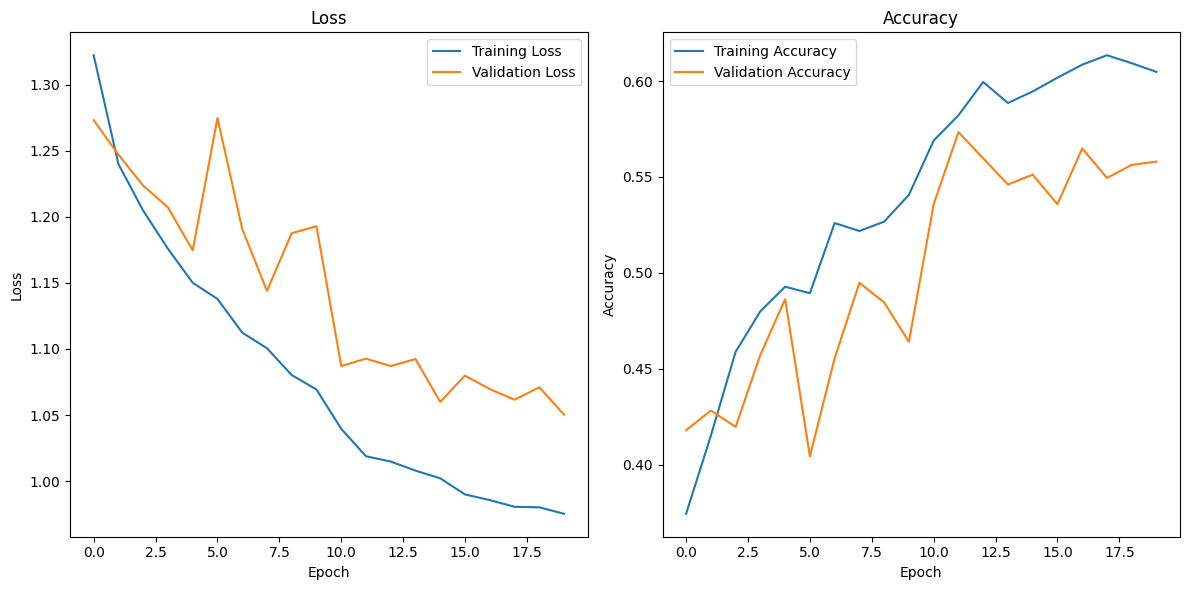

In [ ]:
model256 = ANNWasteClassifier256().to(device)
train(model256, train_loader256, val_loader256, device, 20, 0.001)

With batch normalization, accuracy approved for both the training and validation set. Now, we will start with hyperparameter tuning

# Hyperparameter Tuning

To reduce the numberof neurons in each layer in order to improve the models accuracy we will increase the nunmber of layers of the model to 5

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(1) # set the random seed

class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.name = "ANNWasteClassifier256"
        self.layer1 = nn.Linear(3*256*256, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.layer4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64, 4)

    def forward(self, img):
        # Determine the batch size dynamically
        batch_size = img.size(0)

        flattened = img.view(-1, 3*256*256)
        x = F.relu(self.bn1(self.layer1(flattened)))
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.bn3(self.layer3(x)))
        x = F.relu(self.bn4(self.layer4(x)))
        output = self.layer5(x)
        return output
print('done')


done


Epoch 1, Train Loss: 1.2767, Train Acc: 0.3975, Validation Acc: 0.4454
Epoch 2, Train Loss: 1.1876, Train Acc: 0.4476, Validation Acc: 0.4710
Epoch 3, Train Loss: 1.1335, Train Acc: 0.5004, Validation Acc: 0.4693
Epoch 4, Train Loss: 1.0910, Train Acc: 0.5335, Validation Acc: 0.4863
Epoch 5, Train Loss: 1.0602, Train Acc: 0.5445, Validation Acc: 0.5461
Epoch 6, Train Loss: 1.0289, Train Acc: 0.5735, Validation Acc: 0.4898
Epoch 7, Train Loss: 1.0148, Train Acc: 0.5836, Validation Acc: 0.5512
Epoch 8, Train Loss: 0.9977, Train Acc: 0.5859, Validation Acc: 0.5188
Epoch 9, Train Loss: 0.9684, Train Acc: 0.6014, Validation Acc: 0.5683
Epoch 10, Train Loss: 0.9431, Train Acc: 0.6093, Validation Acc: 0.5751
Epoch 11, Train Loss: 0.8831, Train Acc: 0.6492, Validation Acc: 0.5973
Epoch 12, Train Loss: 0.8492, Train Acc: 0.6665, Validation Acc: 0.6280
Epoch 13, Train Loss: 0.8391, Train Acc: 0.6711, Validation Acc: 0.6314
Epoch 14, Train Loss: 0.8309, Train Acc: 0.6824, Validation Acc: 0.6348
E

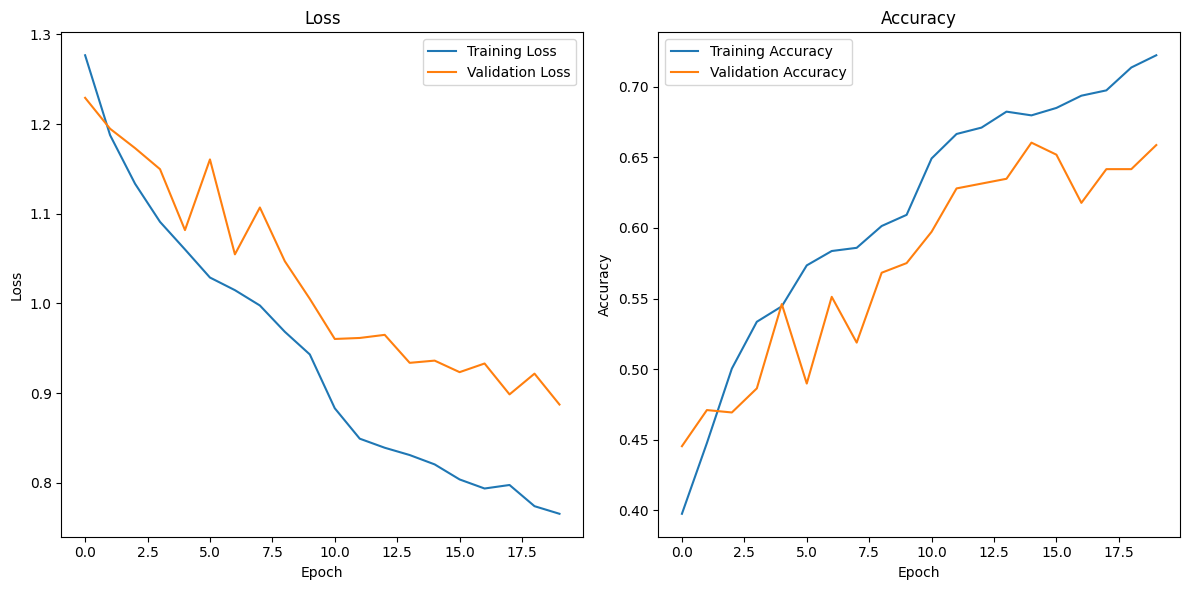

In [ ]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 20, 0.001)

In order to allow the model to converge faster, we increased the number of epochs from 20 to 30

Epoch 1, Train Loss: 1.2847, Train Acc: 0.3964, Validation Acc: 0.4249
Epoch 2, Train Loss: 1.1929, Train Acc: 0.4491, Validation Acc: 0.5034
Epoch 3, Train Loss: 1.1340, Train Acc: 0.5117, Validation Acc: 0.4727
Epoch 4, Train Loss: 1.0992, Train Acc: 0.5339, Validation Acc: 0.5017
Epoch 5, Train Loss: 1.0633, Train Acc: 0.5448, Validation Acc: 0.5307
Epoch 6, Train Loss: 1.0350, Train Acc: 0.5739, Validation Acc: 0.5034
Epoch 7, Train Loss: 1.0077, Train Acc: 0.5727, Validation Acc: 0.4949
Epoch 8, Train Loss: 0.9856, Train Acc: 0.5972, Validation Acc: 0.5648
Epoch 9, Train Loss: 0.9582, Train Acc: 0.6115, Validation Acc: 0.5478
Epoch 10, Train Loss: 0.9492, Train Acc: 0.6059, Validation Acc: 0.5700
Epoch 11, Train Loss: 0.8784, Train Acc: 0.6549, Validation Acc: 0.6058
Epoch 12, Train Loss: 0.8412, Train Acc: 0.6729, Validation Acc: 0.6263
Epoch 13, Train Loss: 0.8367, Train Acc: 0.6703, Validation Acc: 0.6195
Epoch 14, Train Loss: 0.8235, Train Acc: 0.6767, Validation Acc: 0.6246
E

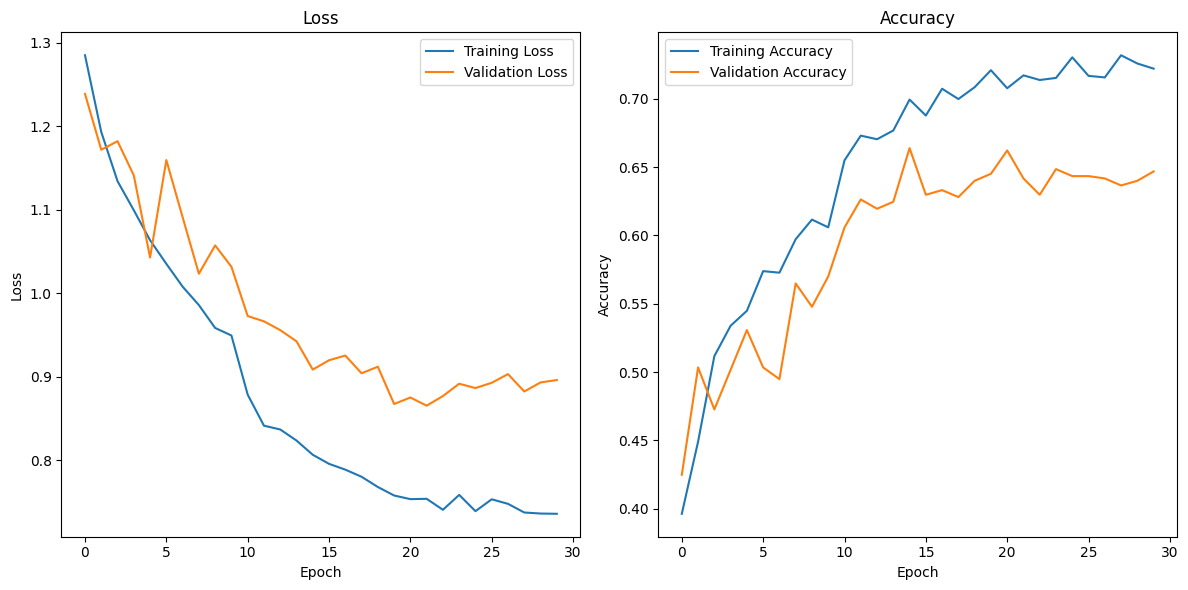

In [ ]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 30, 0.001)

Epoch 1, Train Loss: 1.2704, Train Acc: 0.4024, Validation Acc: 0.4232
Epoch 2, Train Loss: 1.1884, Train Acc: 0.4540, Validation Acc: 0.5102
Epoch 3, Train Loss: 1.1264, Train Acc: 0.5075, Validation Acc: 0.5000
Epoch 4, Train Loss: 1.0890, Train Acc: 0.5290, Validation Acc: 0.5358
Epoch 5, Train Loss: 1.0659, Train Acc: 0.5422, Validation Acc: 0.5461


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff64a4616c0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff64a4616c0>
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError:   File "/usr/lib/python3.10/multiprocessing/pro

Epoch 6, Train Loss: 1.0361, Train Acc: 0.5656, Validation Acc: 0.5017


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff64a4616c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff64a4616c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 7, Train Loss: 1.0090, Train Acc: 0.5686, Validation Acc: 0.4881


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff64a4616c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff64a4616c0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Epoch 8, Train Loss: 0.9923, Train Acc: 0.5791, Validation Acc: 0.5427
Epoch 9, Train Loss: 0.9614, Train Acc: 0.5965, Validation Acc: 0.5392
Epoch 10, Train Loss: 0.9415, Train Acc: 0.6123, Validation Acc: 0.5785
Epoch 11, Train Loss: 0.8762, Train Acc: 0.6473, Validation Acc: 0.6058
Epoch 12, Train Loss: 0.8413, Train Acc: 0.6662, Validation Acc: 0.6297
Epoch 13, Train Loss: 0.8325, Train Acc: 0.6658, Validation Acc: 0.6229
Epoch 14, Train Loss: 0.8250, Train Acc: 0.6891, Validation Acc: 0.6075
Epoch 15, Train Loss: 0.8109, Train Acc: 0.6854, Validation Acc: 0.6365
Epoch 16, Train Loss: 0.8014, Train Acc: 0.6786, Validation Acc: 0.6246
Epoch 17, Train Loss: 0.7902, Train Acc: 0.7080, Validation Acc: 0.6126
Epoch 18, Train Loss: 0.7827, Train Acc: 0.7095, Validation Acc: 0.6143
Epoch 19, Train Loss: 0.7724, Train Acc: 0.7027, Validation Acc: 0.6229
Epoch 20, Train Loss: 0.7608, Train Acc: 0.7084, Validation Acc: 0.6263
Epoch 21, Train Loss: 0.7525, Train Acc: 0.7080, Validation Acc: 0

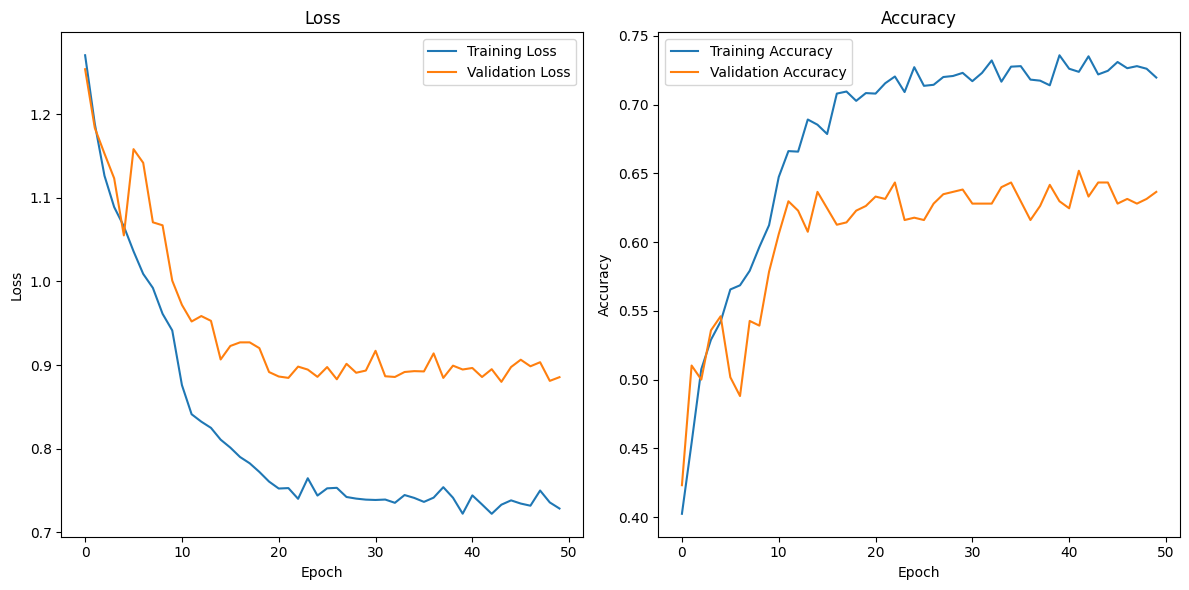

In [20]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 50, 0.001)

When setting the number of epochs to 30, the convergence was more exponential but there is still a lot of fluctuation and underfitting. To help with the fluctuation we will decrease the learning rate from 0.0001 to 0.00005. Additionally, we can decrease the number of epochs down to 25 since it plateaus and does not perform significatly better than at 25.

Learning rate of 0.00005 did not help, decreased the accuracy to 0.59 rather than before at 0.62. Try changing lr to 0.0005

at 0.0005 it got to 0.62/0.63, try 0.001

fluctuated up to 0.65, try 0.01

Did not work as well, decreased to 0.62/63. Keep at lr = 0.001

Next try increasing the number of layers since it is still underfitting. Increased from 5 layers to 6
Decreased from 0.65 to approx 0.64
Try increase another layer from 6 to 7
final output of 0.62. Use 5 layers, increase batch size to 64, 0.65 accuracy try batch size 128 final output: 0.48

Epoch 1, Train Loss: 1.2847, Train Acc: 0.3964, Validation Acc: 0.4249
Epoch 2, Train Loss: 1.1929, Train Acc: 0.4491, Validation Acc: 0.5034
Epoch 3, Train Loss: 1.1340, Train Acc: 0.5117, Validation Acc: 0.4727
Epoch 4, Train Loss: 1.0992, Train Acc: 0.5339, Validation Acc: 0.5017
Epoch 5, Train Loss: 1.0633, Train Acc: 0.5448, Validation Acc: 0.5307
Epoch 6, Train Loss: 1.0350, Train Acc: 0.5739, Validation Acc: 0.5034
Epoch 7, Train Loss: 1.0077, Train Acc: 0.5727, Validation Acc: 0.4949
Epoch 8, Train Loss: 0.9856, Train Acc: 0.5972, Validation Acc: 0.5648
Epoch 9, Train Loss: 0.9582, Train Acc: 0.6115, Validation Acc: 0.5478
Epoch 10, Train Loss: 0.9492, Train Acc: 0.6059, Validation Acc: 0.5700
Epoch 11, Train Loss: 0.8784, Train Acc: 0.6549, Validation Acc: 0.6058
Epoch 12, Train Loss: 0.8412, Train Acc: 0.6729, Validation Acc: 0.6263
Epoch 13, Train Loss: 0.8367, Train Acc: 0.6703, Validation Acc: 0.6195
Epoch 14, Train Loss: 0.8235, Train Acc: 0.6767, Validation Acc: 0.6246
E

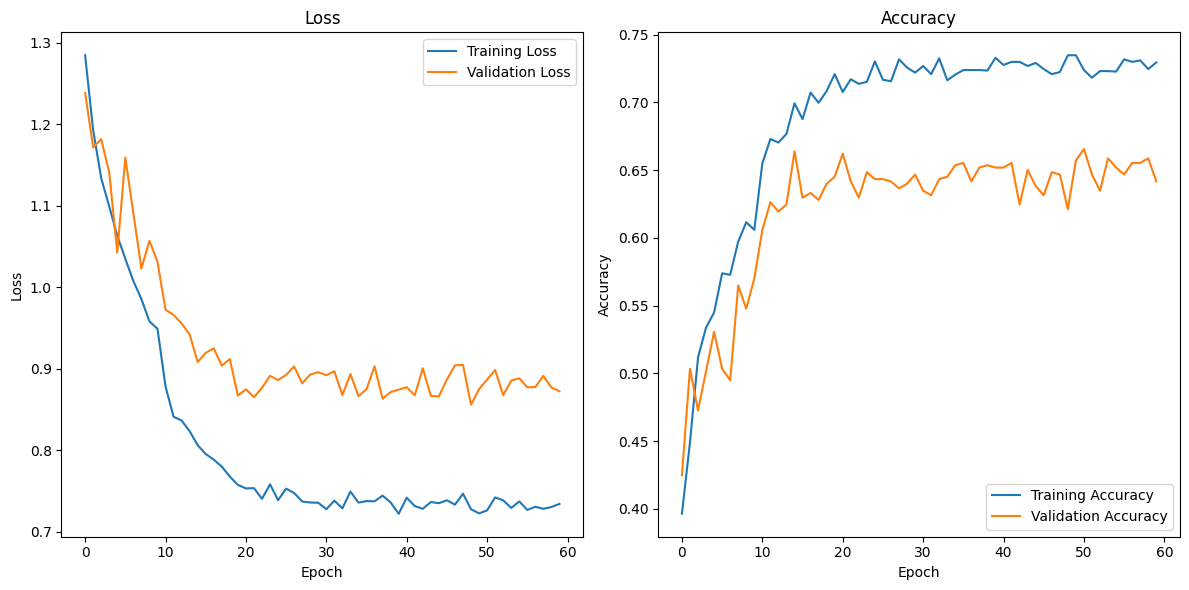

In [ ]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 60, 0.001)

Epoch 1, Train Loss: 1.2976, Train Acc: 0.3794, Validation Acc: 0.4266
Epoch 2, Train Loss: 1.2313, Train Acc: 0.4216, Validation Acc: 0.4266
Epoch 3, Train Loss: 1.1879, Train Acc: 0.4612, Validation Acc: 0.4522
Epoch 4, Train Loss: 1.1544, Train Acc: 0.4695, Validation Acc: 0.4556
Epoch 5, Train Loss: 1.1384, Train Acc: 0.4846, Validation Acc: 0.5102
Epoch 6, Train Loss: 1.1176, Train Acc: 0.5026, Validation Acc: 0.4454
Epoch 7, Train Loss: 1.0993, Train Acc: 0.5004, Validation Acc: 0.5034
Epoch 8, Train Loss: 1.0760, Train Acc: 0.5090, Validation Acc: 0.5341
Epoch 9, Train Loss: 1.0554, Train Acc: 0.5445, Validation Acc: 0.5410
Epoch 10, Train Loss: 1.0241, Train Acc: 0.5486, Validation Acc: 0.5495
Epoch 11, Train Loss: 0.9448, Train Acc: 0.6059, Validation Acc: 0.5887
Epoch 12, Train Loss: 0.9170, Train Acc: 0.6243, Validation Acc: 0.6126
Epoch 13, Train Loss: 0.9060, Train Acc: 0.6307, Validation Acc: 0.6195
Epoch 14, Train Loss: 0.8997, Train Acc: 0.6368, Validation Acc: 0.6160
E

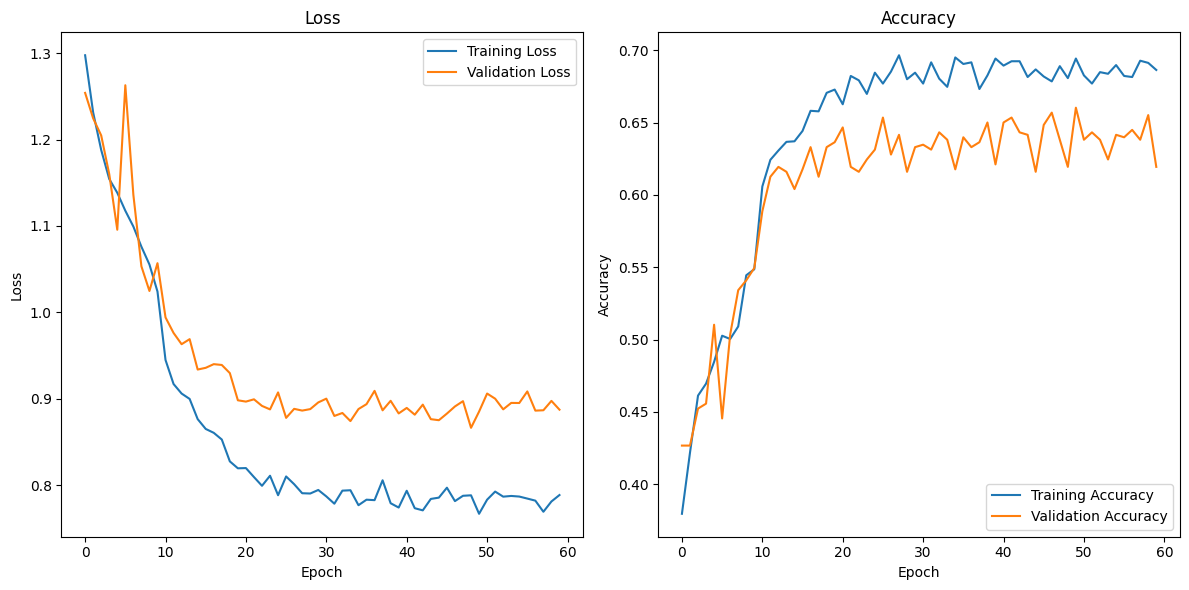

In [ ]:
model256 = ANNWasteClassifier256().to(device)

train(model256, train_loader256, val_loader256, device, 60, 0.01)

Epoch 1, Train Loss: 1.2604, Train Acc: 0.4103, Validation Acc: 0.4078
Epoch 2, Train Loss: 1.1781, Train Acc: 0.4683, Validation Acc: 0.4659
Epoch 3, Train Loss: 1.1243, Train Acc: 0.5230, Validation Acc: 0.4727
Epoch 4, Train Loss: 1.0881, Train Acc: 0.5396, Validation Acc: 0.5034
Epoch 5, Train Loss: 1.0617, Train Acc: 0.5475, Validation Acc: 0.5290
Epoch 6, Train Loss: 1.0208, Train Acc: 0.5844, Validation Acc: 0.4608
Epoch 7, Train Loss: 0.9996, Train Acc: 0.5953, Validation Acc: 0.5000
Epoch 8, Train Loss: 0.9852, Train Acc: 0.5874, Validation Acc: 0.5563
Epoch 9, Train Loss: 0.9431, Train Acc: 0.6258, Validation Acc: 0.5563
Epoch 10, Train Loss: 0.9267, Train Acc: 0.6258, Validation Acc: 0.5580
Epoch 11, Train Loss: 0.8756, Train Acc: 0.6616, Validation Acc: 0.6160
Epoch 12, Train Loss: 0.8355, Train Acc: 0.6937, Validation Acc: 0.6212
Epoch 13, Train Loss: 0.8317, Train Acc: 0.6884, Validation Acc: 0.6263
Epoch 14, Train Loss: 0.8334, Train Acc: 0.6778, Validation Acc: 0.6160
E

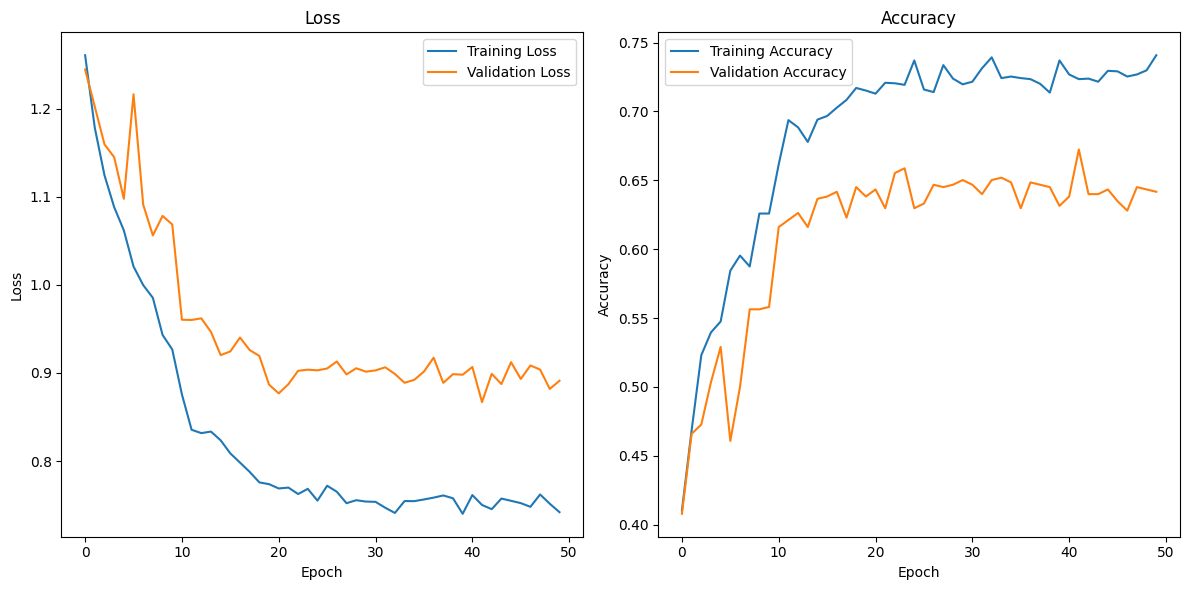

In [ ]:
model256 = ANNWasteClassifier256().to(device)
#print(model256)
train(model256, train_loader256, val_loader256, device, 50, 0.0005)

In [ ]:
#Tuning Batch size
train_loader256 = torch.utils.data.DataLoader(train_data256, batch_size=64, num_workers=4, shuffle=True)
val_loader256 = torch.utils.data.DataLoader(val_data256,  batch_size=64, num_workers=4, shuffle=True)
test_loader256 = torch.utils.data.DataLoader(test_data256, batch_size=64,num_workers=4, shuffle=True)

Epoch 1, Train Loss: 1.2661, Train Acc: 0.4081, Validation Acc: 0.3942
Epoch 2, Train Loss: 1.1676, Train Acc: 0.4808, Validation Acc: 0.4795
Epoch 3, Train Loss: 1.1078, Train Acc: 0.5264, Validation Acc: 0.4676
Epoch 4, Train Loss: 1.0634, Train Acc: 0.5618, Validation Acc: 0.5188
Epoch 5, Train Loss: 1.0209, Train Acc: 0.5791, Validation Acc: 0.4983
Epoch 6, Train Loss: 0.9953, Train Acc: 0.5998, Validation Acc: 0.4932
Epoch 7, Train Loss: 0.9544, Train Acc: 0.6221, Validation Acc: 0.5239
Epoch 8, Train Loss: 0.9362, Train Acc: 0.6345, Validation Acc: 0.5529
Epoch 9, Train Loss: 0.8928, Train Acc: 0.6488, Validation Acc: 0.5102
Epoch 10, Train Loss: 0.8726, Train Acc: 0.6571, Validation Acc: 0.5666
Epoch 11, Train Loss: 0.8086, Train Acc: 0.6903, Validation Acc: 0.6195
Epoch 12, Train Loss: 0.7897, Train Acc: 0.7031, Validation Acc: 0.6399
Epoch 13, Train Loss: 0.7785, Train Acc: 0.7110, Validation Acc: 0.6451
Epoch 14, Train Loss: 0.7521, Train Acc: 0.7332, Validation Acc: 0.6348
E

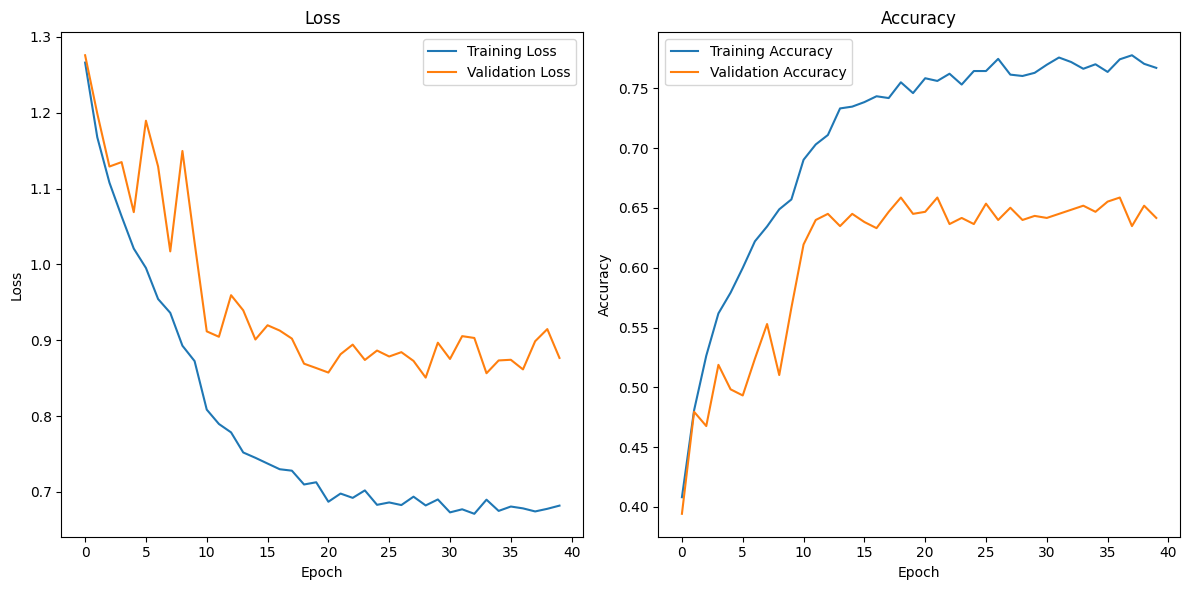

In [ ]:
model256 = ANNWasteClassifier256().to(device)
#print(model256)
train(model256, train_loader256, val_loader256, device, 40, 0.001)

In an attempt to reduce the fluctuations on the validation dataset one thing to do is improve the models ability to generalize. This time, we will increase the number of neurons in each layer for better feature detection.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(1) # set the random seed

class ANNWasteClassifier256(nn.Module):
    def __init__(self):
        super(ANNWasteClassifier256, self).__init__()
        self.layer1 = nn.Linear(3*256*256, 512*2)
        self.bn1 = nn.BatchNorm1d(512*2)
        self.layer2 = nn.Linear(512*2, 256*2)
        self.bn2 = nn.BatchNorm1d(256*2)
        self.layer3 = nn.Linear(256*2, 128*2)
        self.bn3 = nn.BatchNorm1d(128*2)
        self.layer4 = nn.Linear(128*2, 64*2)
        self.bn4 = nn.BatchNorm1d(64*2)
        self.layer5 = nn.Linear(64*2, 4)

    def forward(self, img):
        # Determine the batch size dynamically
        batch_size = img.size(0)

        flattened = img.view(-1, 3*256*256)
        x = F.relu(self.bn1(self.layer1(flattened)))
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.bn3(self.layer3(x)))
        x = F.relu(self.bn4(self.layer4(x)))
        output = self.layer5(x)
        return output
print('done')


done


Epoch 1, Train Loss: 1.2572, Train Acc: 0.4107, Validation Acc: 0.4249
Epoch 2, Train Loss: 1.1663, Train Acc: 0.4608, Validation Acc: 0.5324
Epoch 3, Train Loss: 1.1023, Train Acc: 0.5313, Validation Acc: 0.5222
Epoch 4, Train Loss: 1.0644, Train Acc: 0.5456, Validation Acc: 0.5290
Epoch 5, Train Loss: 1.0232, Train Acc: 0.5701, Validation Acc: 0.5495
Epoch 6, Train Loss: 0.9966, Train Acc: 0.5885, Validation Acc: 0.5034
Epoch 7, Train Loss: 0.9675, Train Acc: 0.5995, Validation Acc: 0.5273
Epoch 8, Train Loss: 0.9453, Train Acc: 0.6176, Validation Acc: 0.5666
Epoch 9, Train Loss: 0.9186, Train Acc: 0.6266, Validation Acc: 0.5461
Epoch 10, Train Loss: 0.9026, Train Acc: 0.6338, Validation Acc: 0.5751
Epoch 11, Train Loss: 0.8211, Train Acc: 0.6809, Validation Acc: 0.6331
Epoch 12, Train Loss: 0.7763, Train Acc: 0.7057, Validation Acc: 0.6433
Epoch 13, Train Loss: 0.7710, Train Acc: 0.7076, Validation Acc: 0.6485
Epoch 14, Train Loss: 0.7625, Train Acc: 0.7035, Validation Acc: 0.6348
E

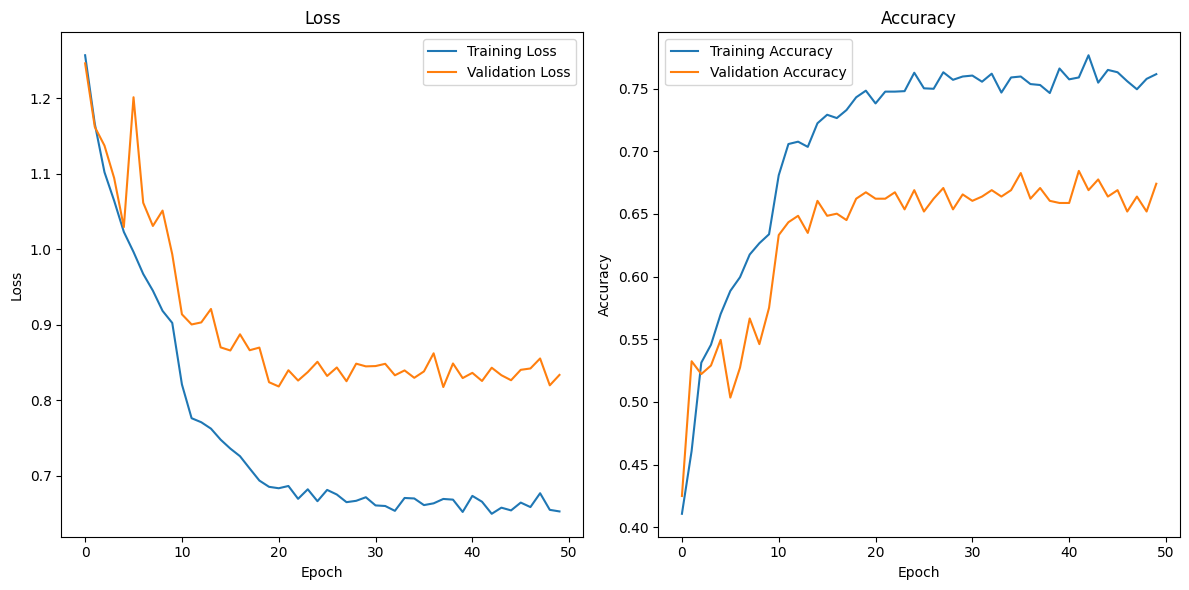

In [ ]:
model256 = ANNWasteClassifier256().to(device)
#print(model256)
train(model256, train_loader256, val_loader256, device, 50, 0.001)

### Best Model



In [21]:
best_model = ANNWasteClassifier256().to(device)
model_path = get_model_name(best_model.name, learning_rate=0.001, epoch=49)
state = torch.load(model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

# Testing Baseline

Using our best model we will see how well it performs on never before seen data

In [ ]:
test_loader256 = torch.utils.data.DataLoader(test_data256, batch_size=64,num_workers=4, shuffle=True)

In [ ]:
print("Final test accuracy: {}.".format(get_accuracy(best_model, test_loader256, device)))

Final test accuracy: 0.6184448462929476.


### Visualizing Test Data

In [22]:
# Load and transform data using ImageFolder

# Compose transformations: RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
unseen_data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])
test_data256 = datasets.ImageFolder(test_dir, transform=data_transform256)
test_loader256 = torch.utils.data.DataLoader(test_data256, batch_size=64,num_workers=4, shuffle=True)


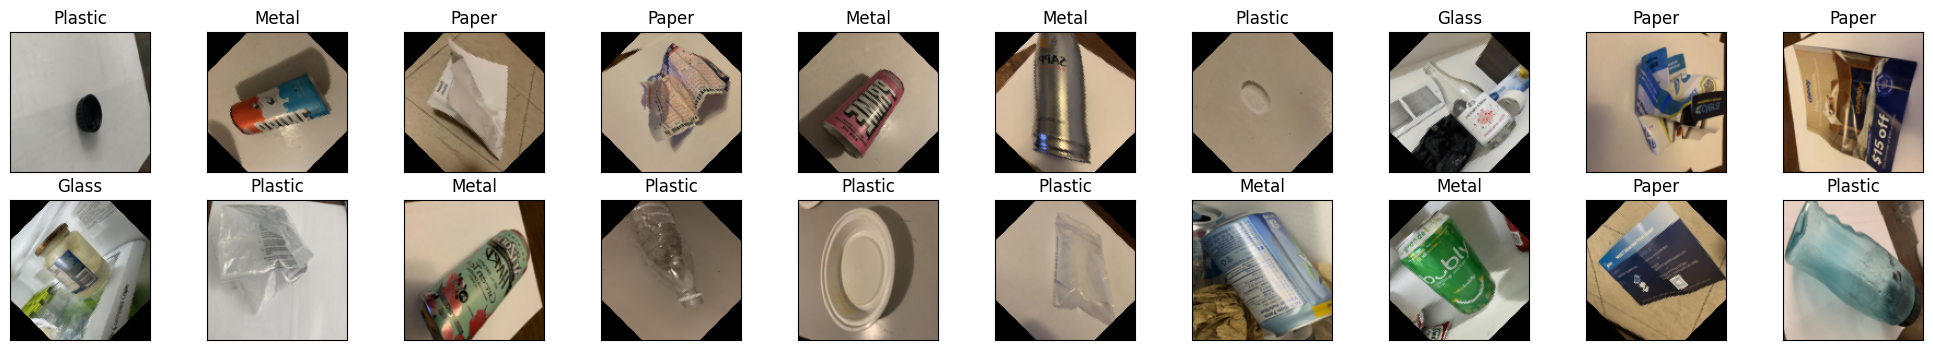

In [ ]:
#
#This is the code to visualize the new data that we collected.
#
#define waste classes - folders in each directory with these names
classes = ['Glass', 'Metal', 'Paper', 'Plastic']

data_loader1 = torch.utils.data.DataLoader(unseen_data, batch_size=20,
                                           num_workers=1, shuffle=True)
# obtain one batch of training images
dataiter1 = iter(data_loader1)
images, labels = next(dataiter1)

#print(labels)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])  # Use class_names instead of classes

This code is used to test the ANN model on new data that has been hand collected.

F1 Score Calculation

In [23]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

# Assuming best_model is your trained model
best_model.eval()  # Put the model in evaluation mode

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the data loader to get predictions for all images
for images, labels in test_loader256:
    images = images.to(device)
    labels = labels.to(device)

    # Perform inference
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Calculate F1 score for each class
f1_scores = f1_score(true_labels, predicted_labels, average=None)

# Print F1 score for each class
for i, score in enumerate(f1_scores):
    print(f"F1 score for class {i}: {score}")

# Calculate and print the average F1 score
average_f1_score = f1_score(true_labels, predicted_labels, average='macro')
print("Average F1 score:", average_f1_score)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


F1 score for class 0: 0.6367041198501873
F1 score for class 1: 0.5869565217391304
F1 score for class 2: 0.7025089605734767
F1 score for class 3: 0.6338028169014085
Average F1 score: 0.6399931047660508


image dimensions:  torch.Size([3, 256, 256])
output probabilities:  tensor([[0.0766, 0.0615, 0.5563, 0.3056]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) sum:  tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
output:  2 with a probability of 0.5562787055969238
label:  tensor(3)


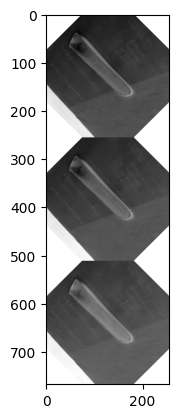

In [ ]:

data_loader1 = torch.utils.data.DataLoader(unseen_data, batch_size=32,
                                           num_workers=1, shuffle=True)
for images, labels in test_loader256:
    # Get the first image from the batch
    image = images[1]
    label = labels[1]
    break  # Break after fetching the first batch

#plot sample image
print('image dimensions: ', image.shape)
plt.imshow(image.view(-1,256),cmap='Greys') #make image 256 x 256

#test new image
out = best_model(image.to(device))
prob = F.softmax(out, dim=1)
print('output probabilities: ', prob, 'sum: ', torch.sum(prob))

#print max index and compare with label
print('output: ', prob.max(1, keepdim=True)[1].item(), 'with a probability of', prob.max(1, keepdim=True)[0].item())
print('label: ', label)